## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the PAPILA dataset. The PAPILA dataset is a glaucoma-focused dataset with 89 full fundus images. The dataset was produced in Spain and is labeled with three-category classification (non-glaucoma, early glaucoma, and advanced glaucoma).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 103.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-PAPILA_models/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)


  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



    normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
    hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc} \n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical Resnet-18 Construction

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### Hybrid Quantum-Classical Resnet-18 Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

# Experiments

In [ ]:
n_epochs = 100
num_classes = 3
batch_size = 32
dataset = "PAPILA"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9052, Training Accuracy: 66.56%, Training AUROC: 0.5168
Validation Loss: 0.9387, Validation Accuracy: 65.82%, Validation AUROC: 0.4547
Epoch [2/100]
Training Loss: 0.8688, Training Accuracy: 67.20%, Training AUROC: 0.5254
Validation Loss: 0.8904, Validation Accuracy: 67.09%, Validation AUROC: 0.4446
Epoch [3/100]
Training Loss: 0.8594, Training Accuracy: 68.17%, Training AUROC: 0.5425
Validation Loss: 0.8722, Validation Accuracy: 67.09%, Validation AUROC: 0.5084
Epoch [4/100]
Training Loss: 0.8391, Training Accuracy: 67.85%, Training AUROC: 0.5713
Validation Loss: 0.8580, Validation Accuracy: 67.09%, Validation AUROC: 0.5497
Epoch [5/100]
Training Loss: 0.8411, Training Accuracy: 67.52%, Training AUROC: 0.5704
Validation Loss: 0.8467, Validation Accuracy: 67.09%, Validation AUROC: 0.5820
Epoch [6/100]
Training Loss: 0.8026, Training Accuracy: 68.17%, Training AUROC: 0.6455
Validation Loss: 0.8329, Validation Accuracy: 67.09%, Validation AUROC: 0.6114
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0014, Training Accuracy: 56.91%, Training AUROC: 0.4830
Validation Loss: 0.9661, Validation Accuracy: 69.62%, Validation AUROC: 0.4385
Epoch [2/100]
Training Loss: 0.9318, Training Accuracy: 64.95%, Training AUROC: 0.5012
Validation Loss: 0.8983, Validation Accuracy: 68.35%, Validation AUROC: 0.5228
Epoch [3/100]
Training Loss: 0.8799, Training Accuracy: 68.17%, Training AUROC: 0.5211
Validation Loss: 0.8642, Validation Accuracy: 68.35%, Validation AUROC: 0.5614
Epoch [4/100]
Training Loss: 0.8629, Training Accuracy: 68.17%, Training AUROC: 0.5443
Validation Loss: 0.8559, Validation Accuracy: 68.35%, Validation AUROC: 0.5709
Epoch [5/100]
Training Loss: 0.8584, Training Accuracy: 68.17%, Training AUROC: 0.5145
Validation Loss: 0.8527, Validation Accuracy: 68.35%, Validation AUROC: 0.5689
Epoch [6/100]
Training Loss: 0.8523, Training Accuracy: 68.17%, Training AUROC: 0.5925
Validation Loss: 0.8498, Validation Accuracy: 68.35%, Validation AUROC: 0.5843
Epoc

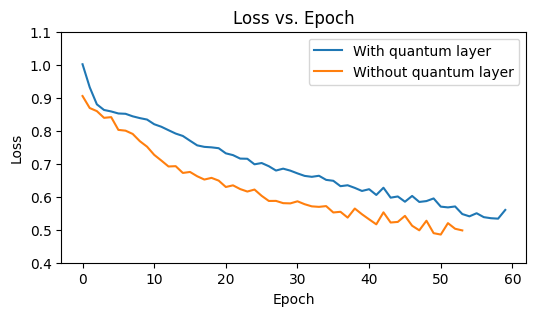

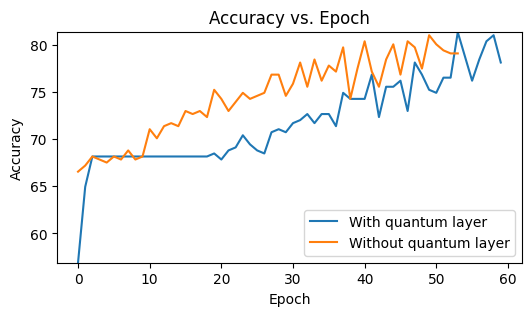

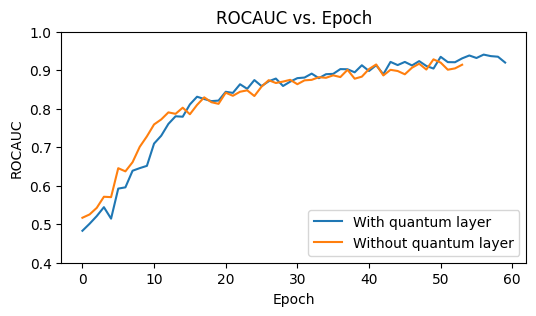

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

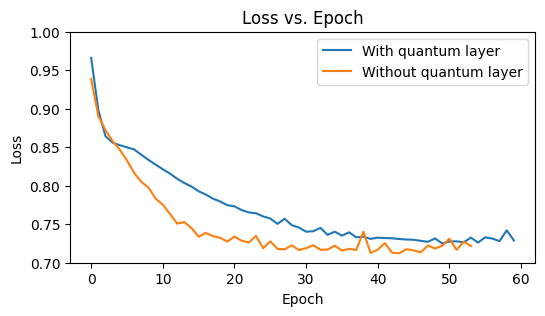

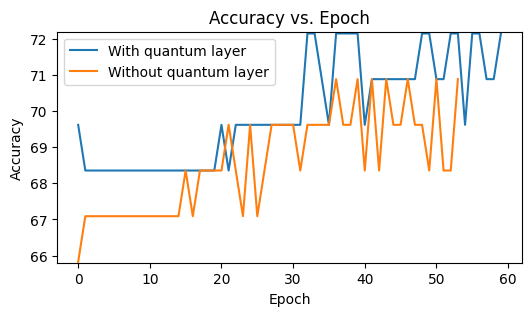

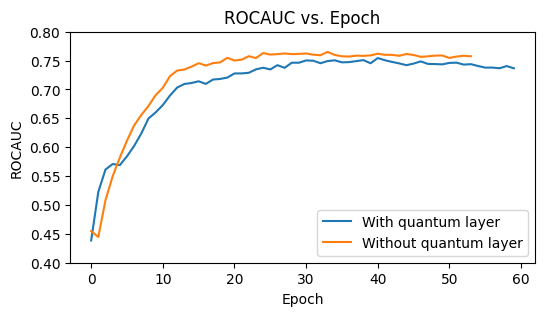

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

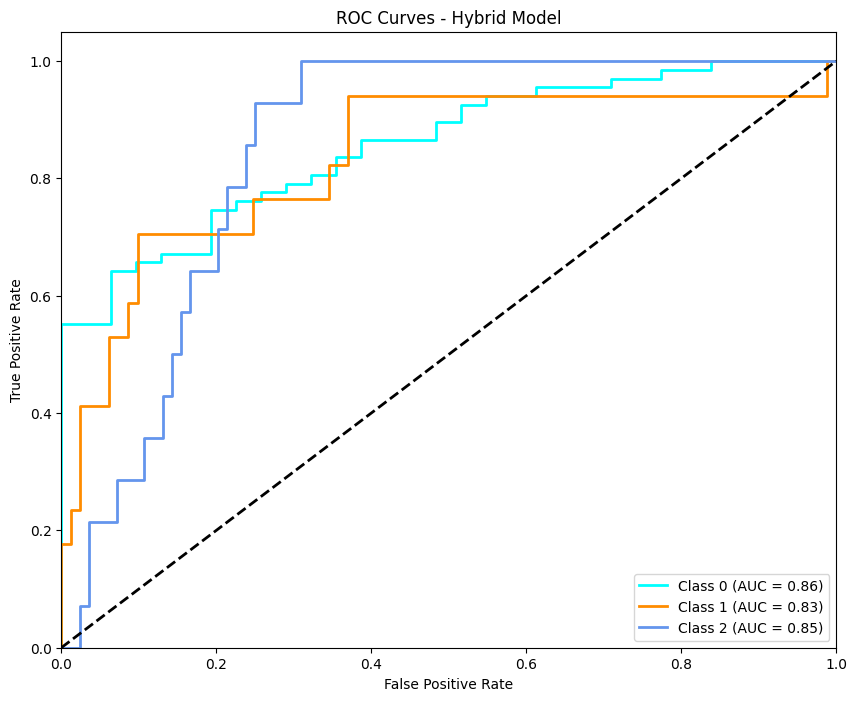

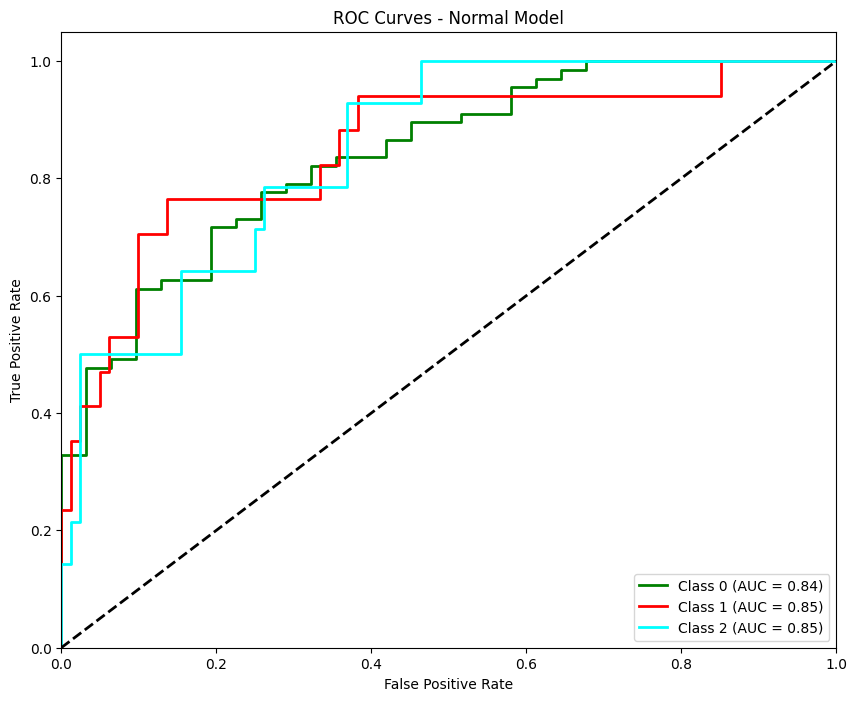


Hybrid Model Metrics:
Accuracy: 0.7347
F1 Score: 0.6825
Precision: 0.6838
Recall: 0.7347
AUROC: 0.8472

Normal Model Metrics:
Accuracy: 0.7347
F1 Score: 0.6916
Precision: 0.7154
Recall: 0.7347
AUROC: 0.8468 



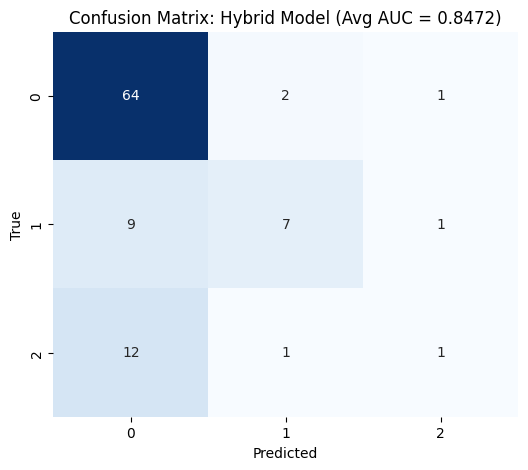

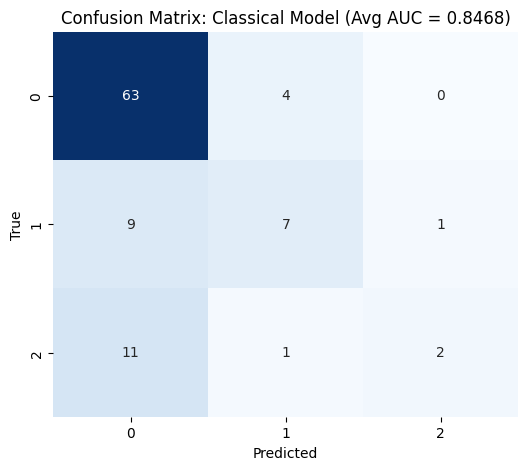

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.3538, Training Accuracy: 18.65%, Training AUROC: 0.5066
Validation Loss: 1.4309, Validation Accuracy: 18.99%, Validation AUROC: 0.4480
Epoch [2/100]
Training Loss: 1.1118, Training Accuracy: 36.66%, Training AUROC: 0.5229
Validation Loss: 1.0422, Validation Accuracy: 43.04%, Validation AUROC: 0.5124
Epoch [3/100]
Training Loss: 0.9030, Training Accuracy: 62.06%, Training AUROC: 0.5354
Validation Loss: 0.8684, Validation Accuracy: 67.09%, Validation AUROC: 0.5639
Epoch [4/100]
Training Loss: 0.8418, Training Accuracy: 68.17%, Training AUROC: 0.5730
Validation Loss: 0.8535, Validation Accuracy: 68.35%, Validation AUROC: 0.5779
Epoch [5/100]
Training Loss: 0.8540, Training Accuracy: 68.17%, Training AUROC: 0.5764
Validation Loss: 0.8450, Validation Accuracy: 68.35%, Validation AUROC: 0.5872
Epoch [6/100]
Training Loss: 0.8375, Training Accuracy: 68.17%, Training AUROC: 0.5958
Validation Loss: 0.8324, Validation Accuracy: 68.35%, Validation AUROC: 0.5998
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1340, Training Accuracy: 25.72%, Training AUROC: 0.4337
Validation Loss: 1.1269, Validation Accuracy: 22.78%, Validation AUROC: 0.5123
Epoch [2/100]
Training Loss: 1.0628, Training Accuracy: 52.09%, Training AUROC: 0.3933
Validation Loss: 0.9962, Validation Accuracy: 64.56%, Validation AUROC: 0.5484
Epoch [3/100]
Training Loss: 0.9487, Training Accuracy: 67.52%, Training AUROC: 0.4503
Validation Loss: 0.8651, Validation Accuracy: 68.35%, Validation AUROC: 0.6082
Epoch [4/100]
Training Loss: 0.8723, Training Accuracy: 68.17%, Training AUROC: 0.4895
Validation Loss: 0.8411, Validation Accuracy: 68.35%, Validation AUROC: 0.5937
Epoch [5/100]
Training Loss: 0.8443, Training Accuracy: 68.17%, Training AUROC: 0.5881
Validation Loss: 0.8410, Validation Accuracy: 68.35%, Validation AUROC: 0.5715
Epoch [6/100]
Training Loss: 0.8443, Training Accuracy: 68.17%, Training AUROC: 0.5897
Validation Loss: 0.8395, Validation Accuracy: 68.35%, Validation AUROC: 0.5688
Epoc

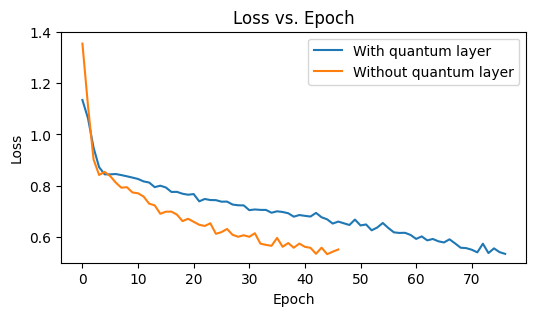

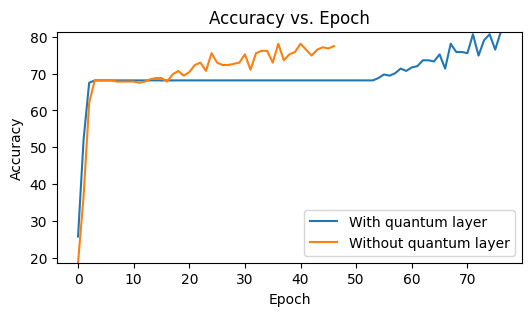

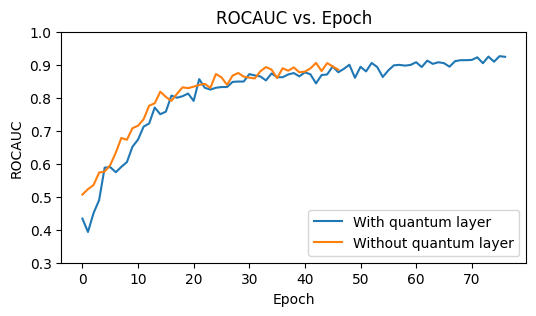

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

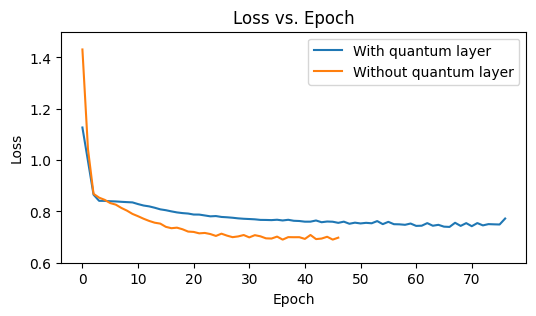

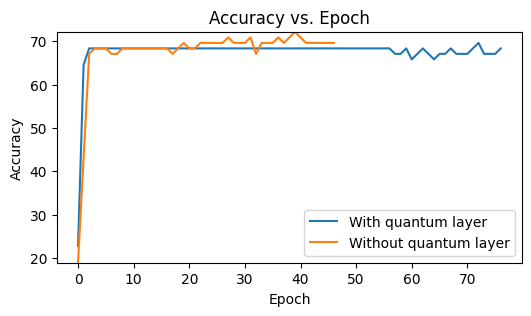

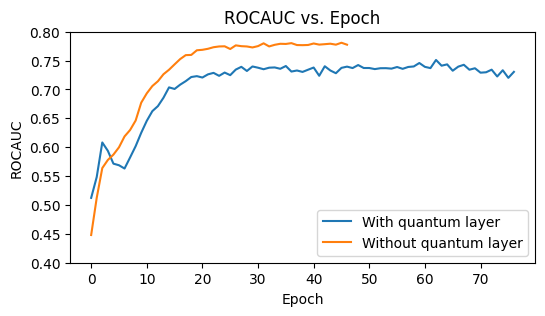

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

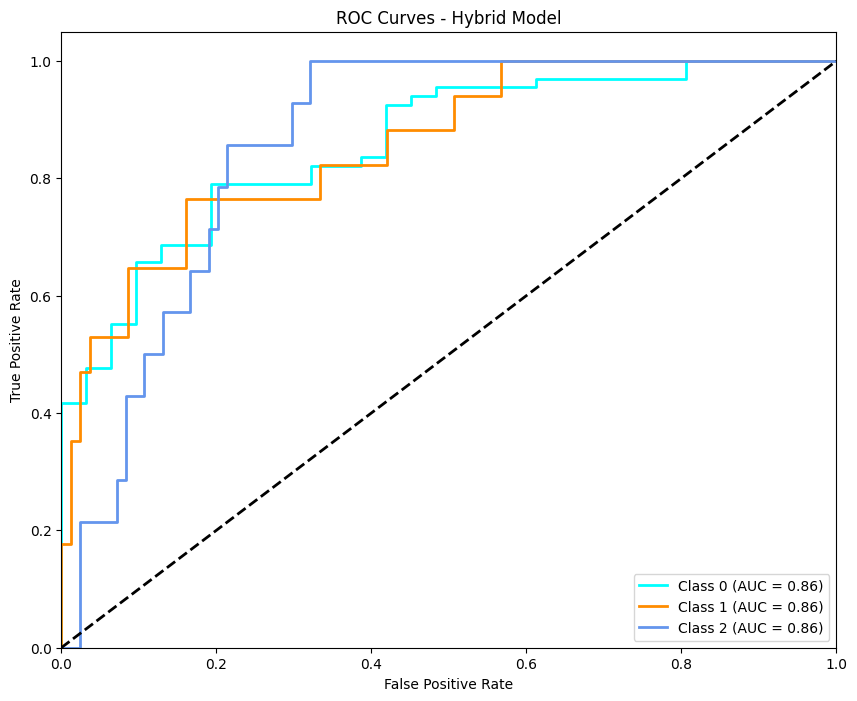

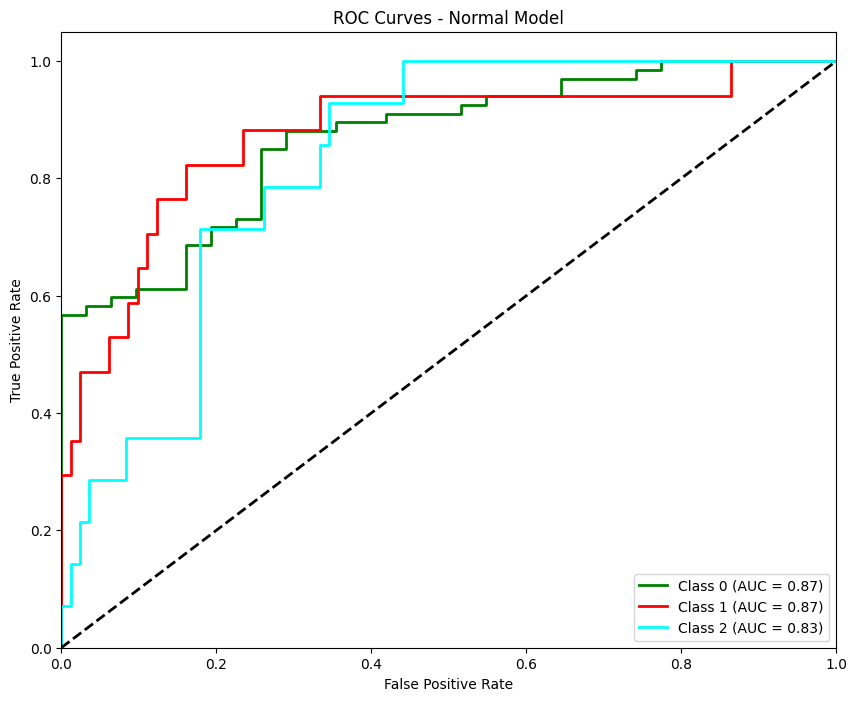


Hybrid Model Metrics:
Accuracy: 0.7245
F1 Score: 0.6572
Precision: 0.6264
Recall: 0.7245
AUROC: 0.8588

Normal Model Metrics:
Accuracy: 0.7449
F1 Score: 0.6861
Precision: 0.7751
Recall: 0.7449
AUROC: 0.8560 



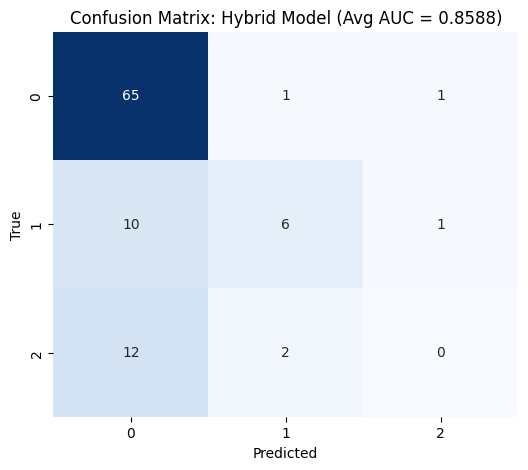

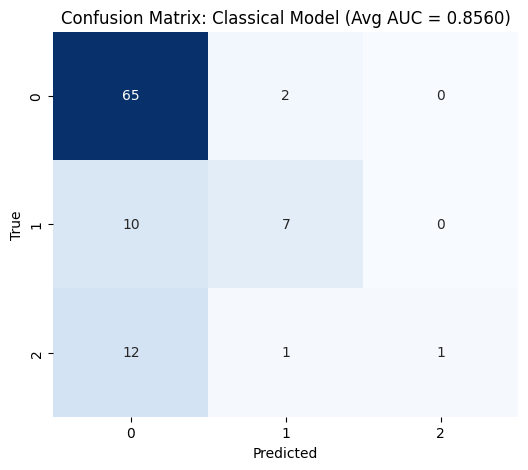

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9751, Training Accuracy: 60.77%, Training AUROC: 0.5647
Validation Loss: 0.8900, Validation Accuracy: 68.35%, Validation AUROC: 0.5123
Epoch [2/100]
Training Loss: 0.8830, Training Accuracy: 68.81%, Training AUROC: 0.5513
Validation Loss: 0.8872, Validation Accuracy: 68.35%, Validation AUROC: 0.5167
Epoch [3/100]
Training Loss: 0.8549, Training Accuracy: 68.17%, Training AUROC: 0.5476
Validation Loss: 0.8800, Validation Accuracy: 68.35%, Validation AUROC: 0.5567
Epoch [4/100]
Training Loss: 0.8635, Training Accuracy: 68.17%, Training AUROC: 0.5519
Validation Loss: 0.8601, Validation Accuracy: 68.35%, Validation AUROC: 0.5768
Epoch [5/100]
Training Loss: 0.8335, Training Accuracy: 68.49%, Training AUROC: 0.5738
Validation Loss: 0.8417, Validation Accuracy: 68.35%, Validation AUROC: 0.5970
Epoch [6/100]
Training Loss: 0.8345, Training Accuracy: 68.49%, Training AUROC: 0.5860
Validation Loss: 0.8291, Validation Accuracy: 68.35%, Validation AUROC: 0.6219
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9200, Training Accuracy: 63.99%, Training AUROC: 0.4639
Validation Loss: 0.8786, Validation Accuracy: 68.35%, Validation AUROC: 0.4853
Epoch [2/100]
Training Loss: 0.8823, Training Accuracy: 67.85%, Training AUROC: 0.4561
Validation Loss: 0.8641, Validation Accuracy: 68.35%, Validation AUROC: 0.4796
Epoch [3/100]
Training Loss: 0.8571, Training Accuracy: 68.17%, Training AUROC: 0.4861
Validation Loss: 0.8517, Validation Accuracy: 68.35%, Validation AUROC: 0.4871
Epoch [4/100]
Training Loss: 0.8503, Training Accuracy: 68.17%, Training AUROC: 0.4915
Validation Loss: 0.8434, Validation Accuracy: 68.35%, Validation AUROC: 0.5211
Epoch [5/100]
Training Loss: 0.8469, Training Accuracy: 68.17%, Training AUROC: 0.4938
Validation Loss: 0.8383, Validation Accuracy: 68.35%, Validation AUROC: 0.5538
Epoch [6/100]
Training Loss: 0.8417, Training Accuracy: 68.17%, Training AUROC: 0.5473
Validation Loss: 0.8362, Validation Accuracy: 68.35%, Validation AUROC: 0.5759
Epoc

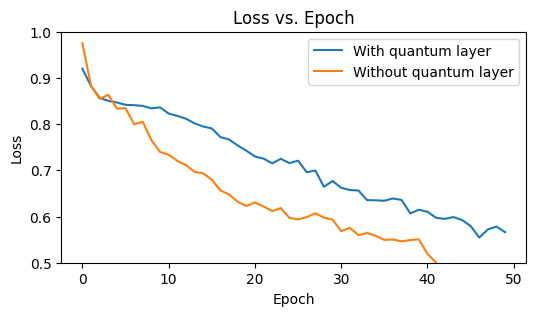

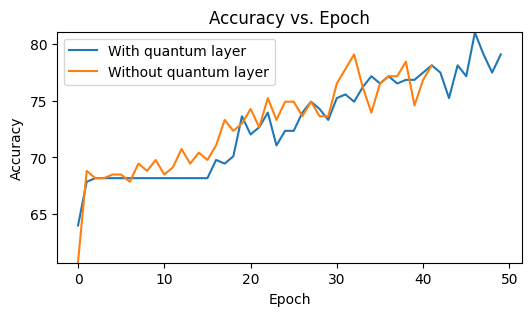

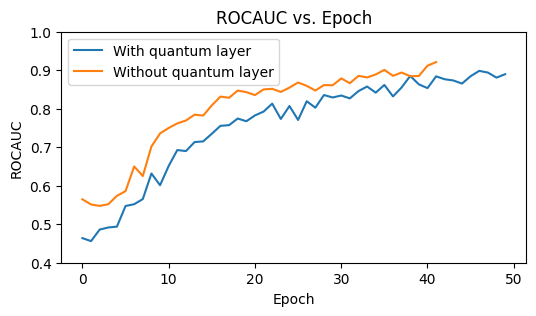

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

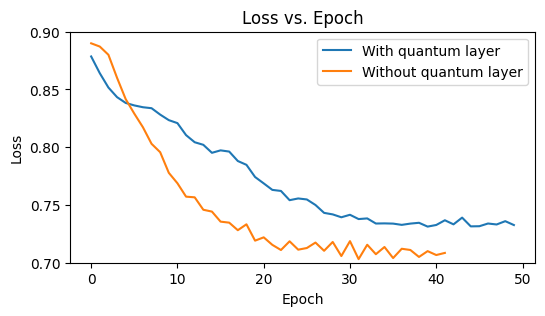

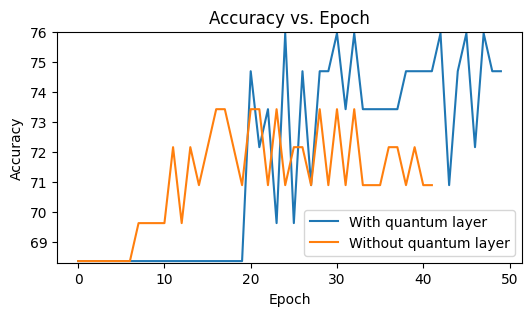

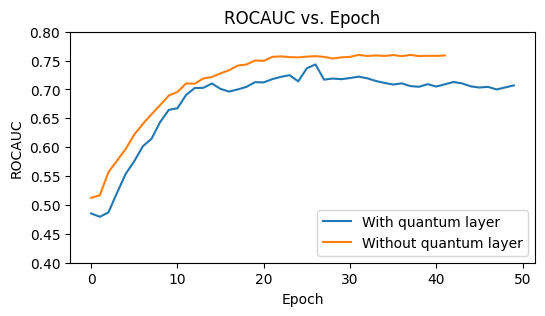

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


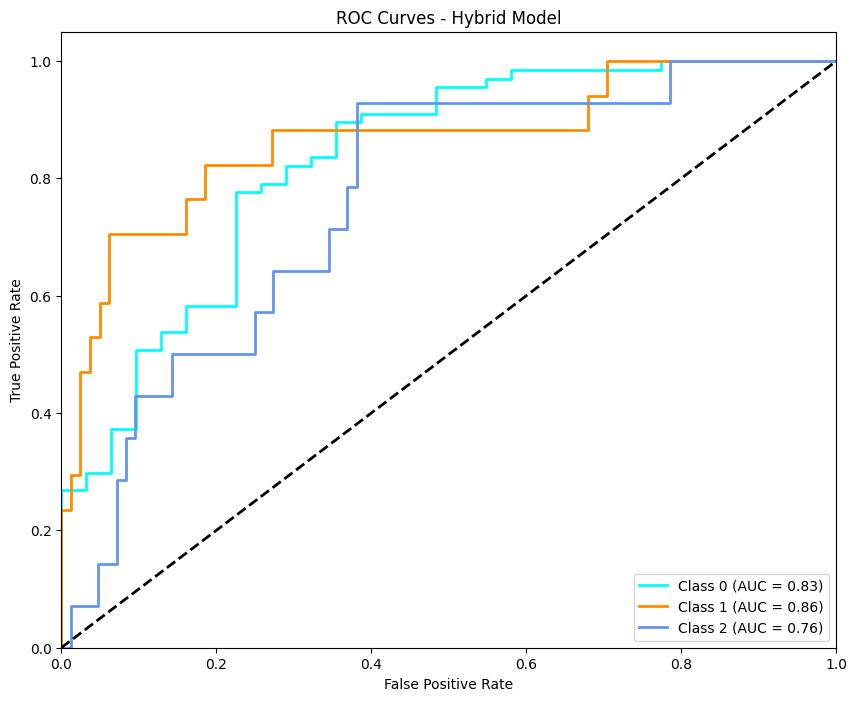

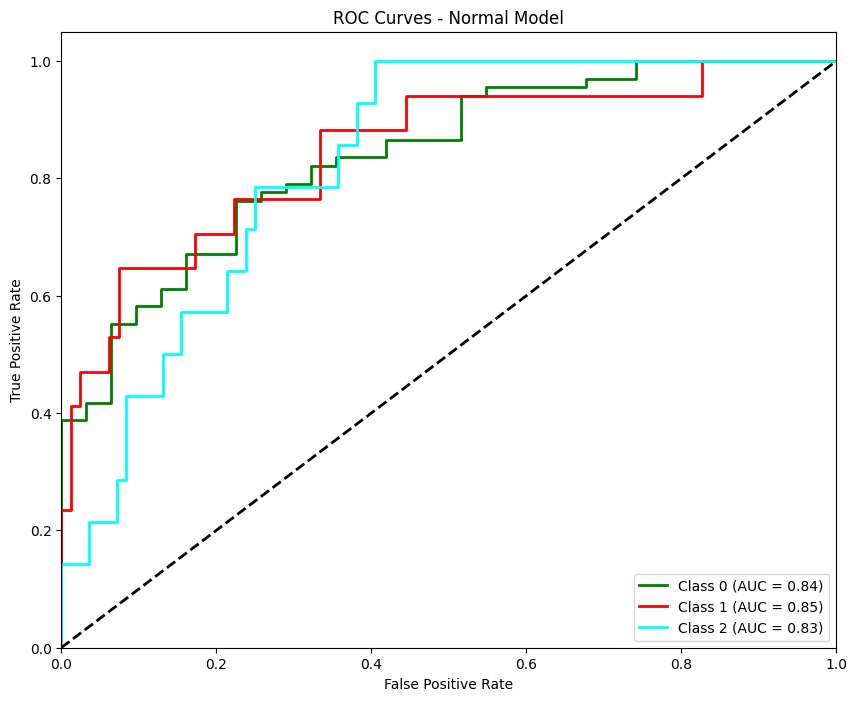


Hybrid Model Metrics:
Accuracy: 0.7653
F1 Score: 0.7066
Precision: 0.6563
Recall: 0.7653
AUROC: 0.8202

Normal Model Metrics:
Accuracy: 0.7653
F1 Score: 0.7144
Precision: 0.7939
Recall: 0.7653
AUROC: 0.8381 



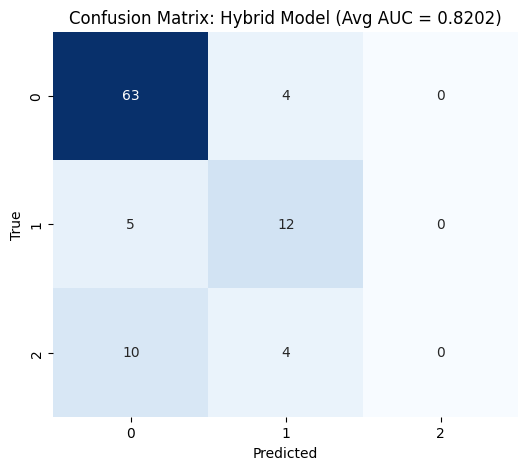

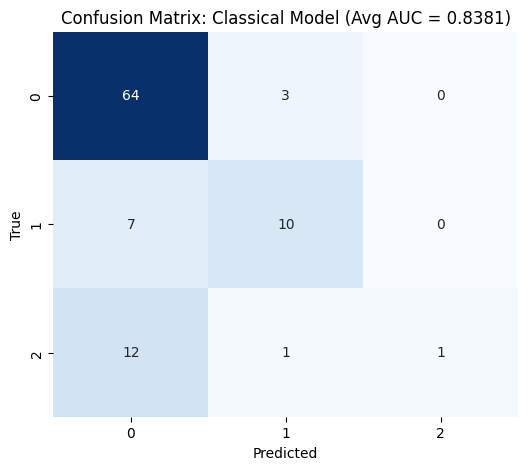

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0086, Training Accuracy: 49.52%, Training AUROC: 0.5471
Validation Loss: 1.0972, Validation Accuracy: 36.71%, Validation AUROC: 0.5284
Epoch [2/100]
Training Loss: 0.8855, Training Accuracy: 65.59%, Training AUROC: 0.5769
Validation Loss: 0.9288, Validation Accuracy: 67.09%, Validation AUROC: 0.5115
Epoch [3/100]
Training Loss: 0.8638, Training Accuracy: 68.17%, Training AUROC: 0.5296
Validation Loss: 0.8630, Validation Accuracy: 68.35%, Validation AUROC: 0.5425
Epoch [4/100]
Training Loss: 0.8450, Training Accuracy: 68.17%, Training AUROC: 0.5902
Validation Loss: 0.8572, Validation Accuracy: 68.35%, Validation AUROC: 0.5723
Epoch [5/100]
Training Loss: 0.8230, Training Accuracy: 68.17%, Training AUROC: 0.6201
Validation Loss: 0.8405, Validation Accuracy: 68.35%, Validation AUROC: 0.5934
Epoch [6/100]
Training Loss: 0.8148, Training Accuracy: 68.81%, Training AUROC: 0.6308
Validation Loss: 0.8327, Validation Accuracy: 68.35%, Validation AUROC: 0.6098
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.2901, Training Accuracy: 18.01%, Training AUROC: 0.4438
Validation Loss: 1.2644, Validation Accuracy: 17.72%, Validation AUROC: 0.5603
Epoch [2/100]
Training Loss: 1.2160, Training Accuracy: 18.01%, Training AUROC: 0.4681
Validation Loss: 1.1810, Validation Accuracy: 17.72%, Validation AUROC: 0.5581
Epoch [3/100]
Training Loss: 1.1416, Training Accuracy: 18.01%, Training AUROC: 0.4330
Validation Loss: 1.1184, Validation Accuracy: 17.72%, Validation AUROC: 0.5430
Epoch [4/100]
Training Loss: 1.0983, Training Accuracy: 18.01%, Training AUROC: 0.5072
Validation Loss: 1.0940, Validation Accuracy: 17.72%, Validation AUROC: 0.5330
Epoch [5/100]
Training Loss: 1.0881, Training Accuracy: 18.01%, Training AUROC: 0.5052
Validation Loss: 1.0823, Validation Accuracy: 17.72%, Validation AUROC: 0.5339
Epoch [6/100]
Training Loss: 1.0763, Training Accuracy: 18.01%, Training AUROC: 0.5075
Validation Loss: 1.0710, Validation Accuracy: 17.72%, Validation AUROC: 0.5415
Epoc

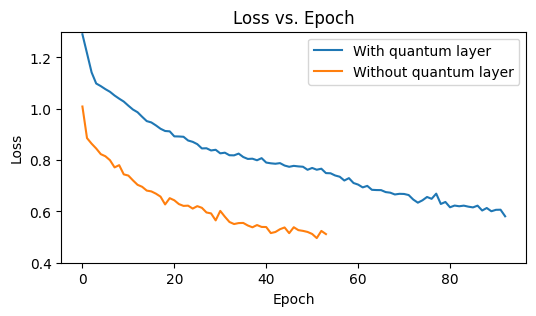

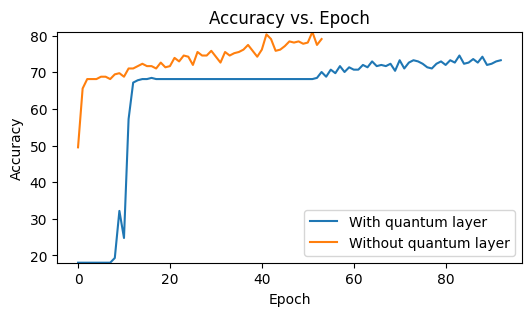

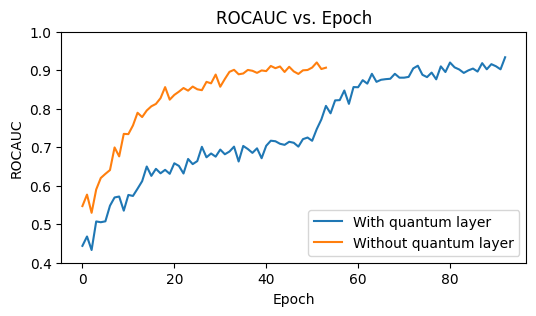

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

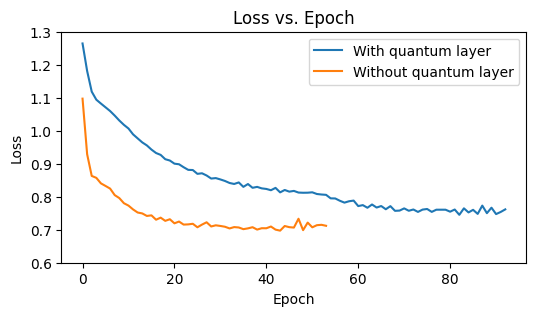

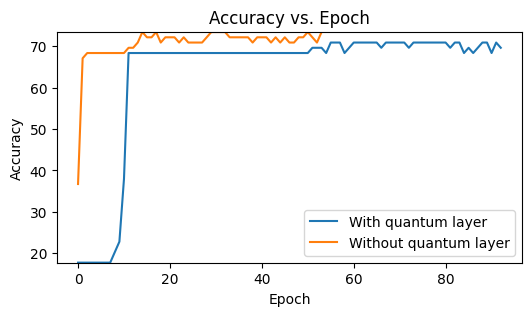

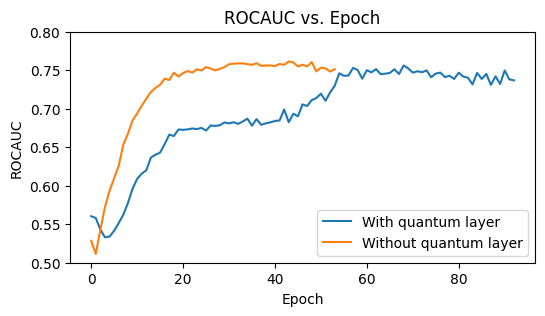

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


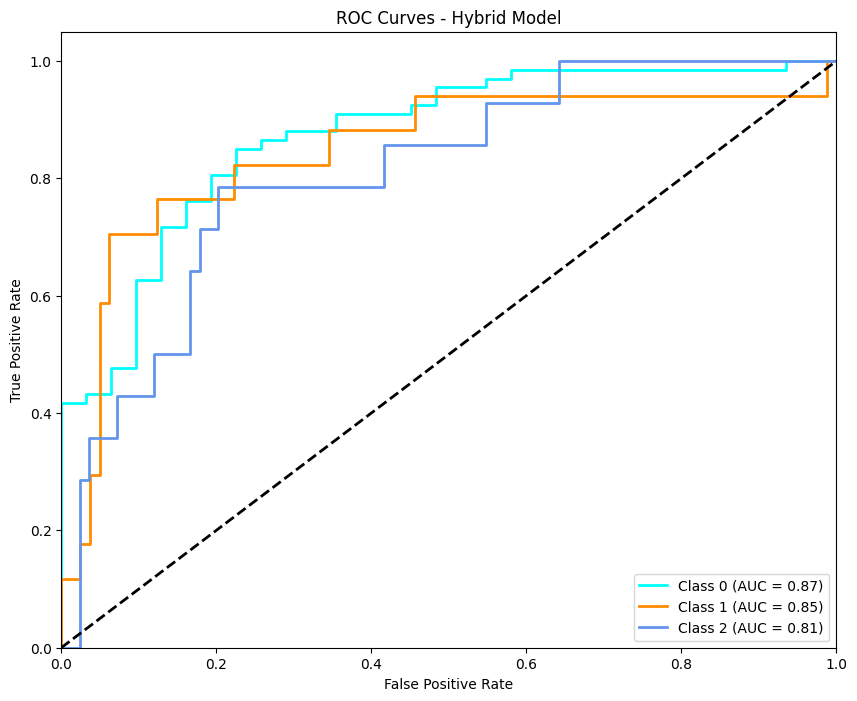

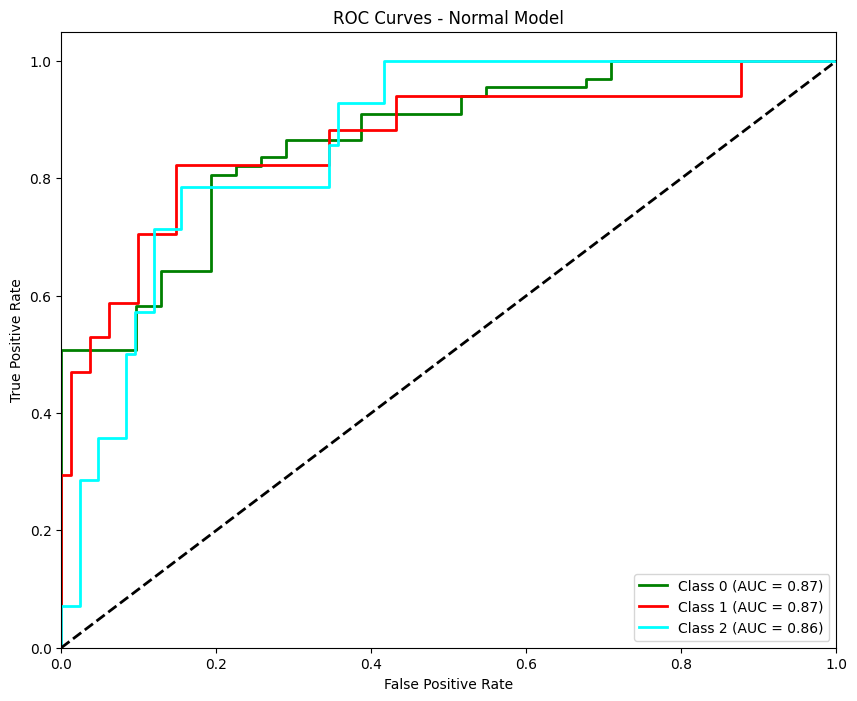


Hybrid Model Metrics:
Accuracy: 0.6939
F1 Score: 0.5923
Precision: 0.5515
Recall: 0.6939
AUROC: 0.8439

Normal Model Metrics:
Accuracy: 0.7347
F1 Score: 0.7006
Precision: 0.7034
Recall: 0.7347
AUROC: 0.8652 



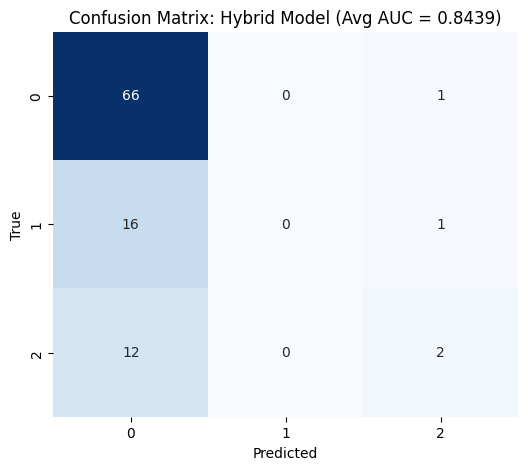

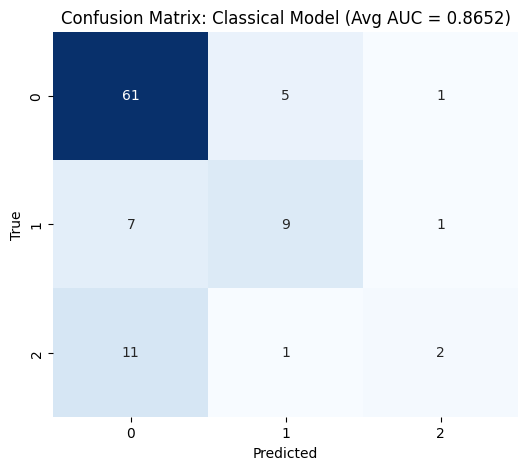

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=3)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9659, Training Accuracy: 58.84%, Training AUROC: 0.4956
Validation Loss: 0.8669, Validation Accuracy: 68.35%, Validation AUROC: 0.5261
Epoch [2/100]
Training Loss: 0.8872, Training Accuracy: 68.17%, Training AUROC: 0.4909
Validation Loss: 0.8600, Validation Accuracy: 68.35%, Validation AUROC: 0.5184
Epoch [3/100]
Training Loss: 0.8506, Training Accuracy: 68.17%, Training AUROC: 0.5238
Validation Loss: 0.8713, Validation Accuracy: 68.35%, Validation AUROC: 0.5370
Epoch [4/100]
Training Loss: 0.8478, Training Accuracy: 68.17%, Training AUROC: 0.5509
Validation Loss: 0.8606, Validation Accuracy: 68.35%, Validation AUROC: 0.5396
Epoch [5/100]
Training Loss: 0.8338, Training Accuracy: 68.49%, Training AUROC: 0.5670
Validation Loss: 0.8440, Validation Accuracy: 69.62%, Validation AUROC: 0.5666
Epoch [6/100]
Training Loss: 0.8165, Training Accuracy: 68.17%, Training AUROC: 0.5983
Validation Loss: 0.8280, Validation Accuracy: 69.62%, Validation AUROC: 0.5930
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9654, Training Accuracy: 63.34%, Training AUROC: 0.4829
Validation Loss: 0.9836, Validation Accuracy: 58.23%, Validation AUROC: 0.5084
Epoch [2/100]
Training Loss: 0.9011, Training Accuracy: 67.52%, Training AUROC: 0.5015
Validation Loss: 0.8945, Validation Accuracy: 67.09%, Validation AUROC: 0.4976
Epoch [3/100]
Training Loss: 0.8675, Training Accuracy: 67.85%, Training AUROC: 0.4996
Validation Loss: 0.8650, Validation Accuracy: 68.35%, Validation AUROC: 0.5004
Epoch [4/100]
Training Loss: 0.8537, Training Accuracy: 68.17%, Training AUROC: 0.5111
Validation Loss: 0.8569, Validation Accuracy: 68.35%, Validation AUROC: 0.5076
Epoch [5/100]
Training Loss: 0.8485, Training Accuracy: 68.17%, Training AUROC: 0.5358
Validation Loss: 0.8517, Validation Accuracy: 68.35%, Validation AUROC: 0.5306
Epoch [6/100]
Training Loss: 0.8472, Training Accuracy: 68.17%, Training AUROC: 0.5516
Validation Loss: 0.8490, Validation Accuracy: 68.35%, Validation AUROC: 0.5468
Epoc

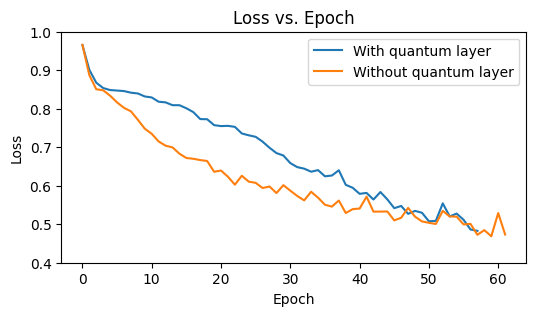

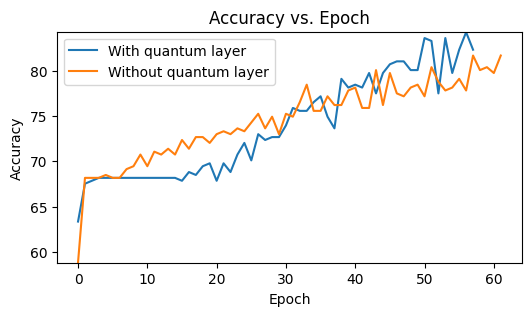

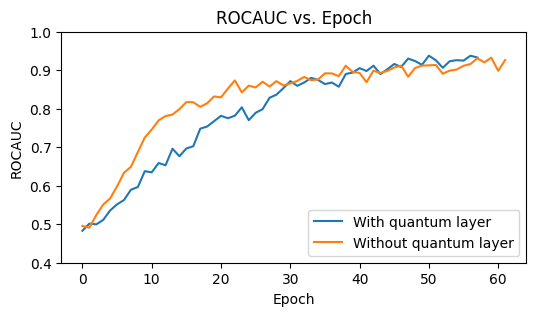

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

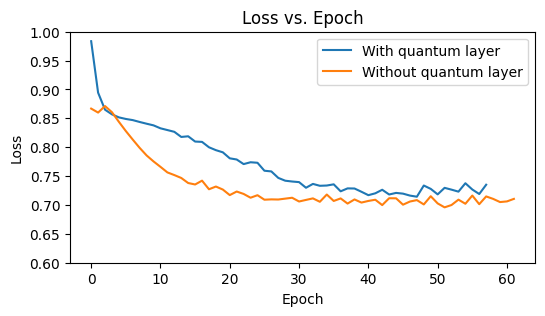

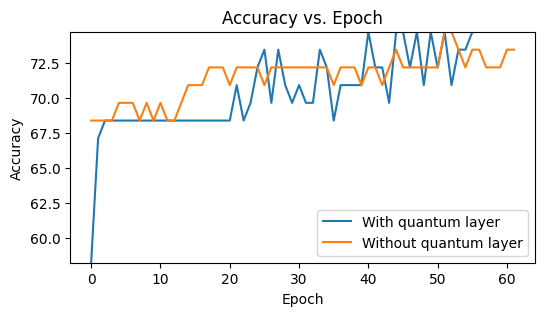

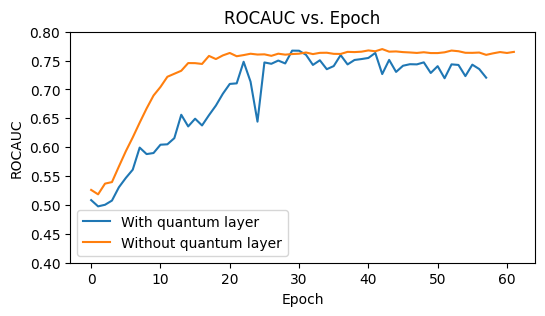

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

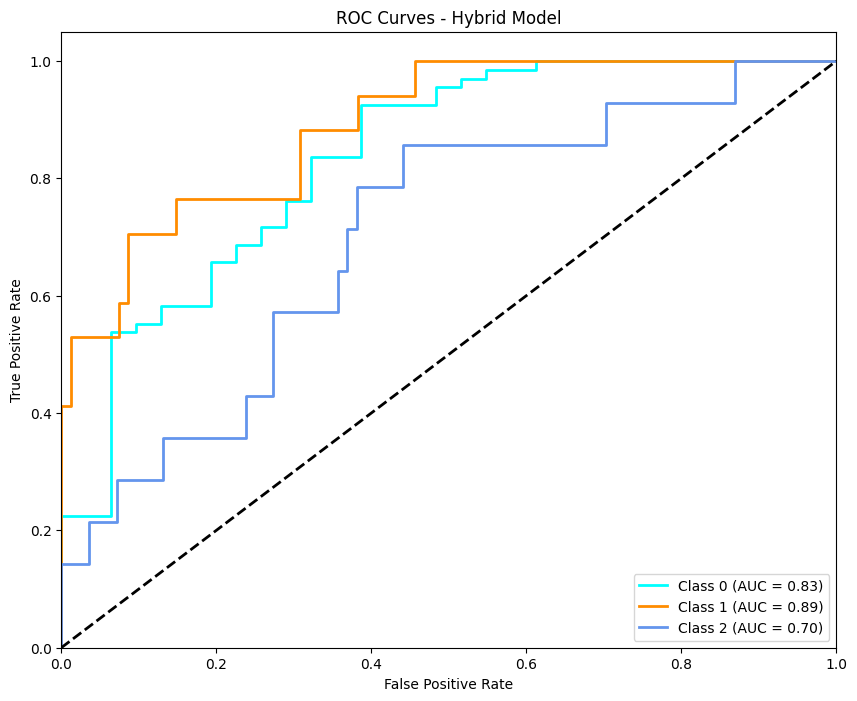

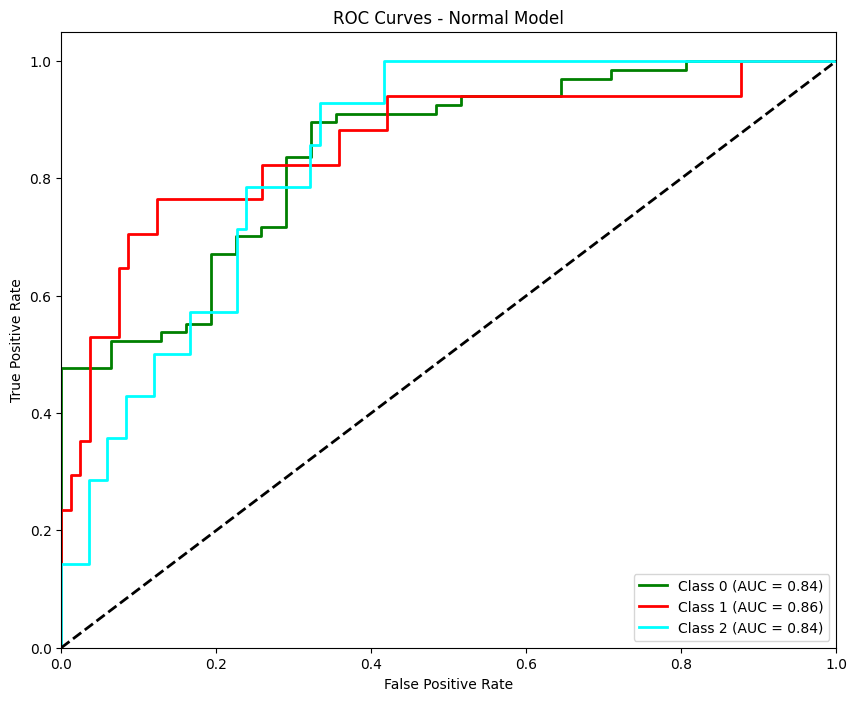


Hybrid Model Metrics:
Accuracy: 0.7551
F1 Score: 0.7024
Precision: 0.6569
Recall: 0.7551
AUROC: 0.8094

Normal Model Metrics:
Accuracy: 0.7449
F1 Score: 0.6993
Precision: 0.7314
Recall: 0.7449
AUROC: 0.8464 



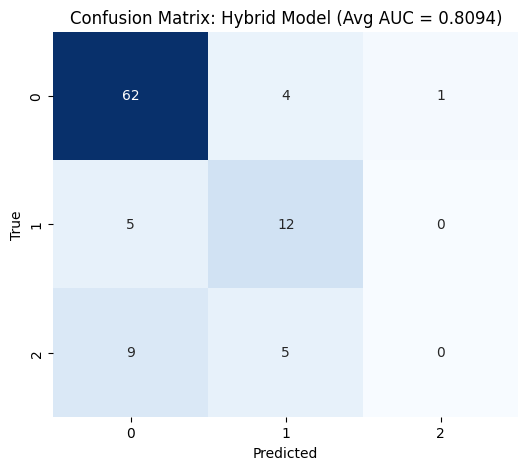

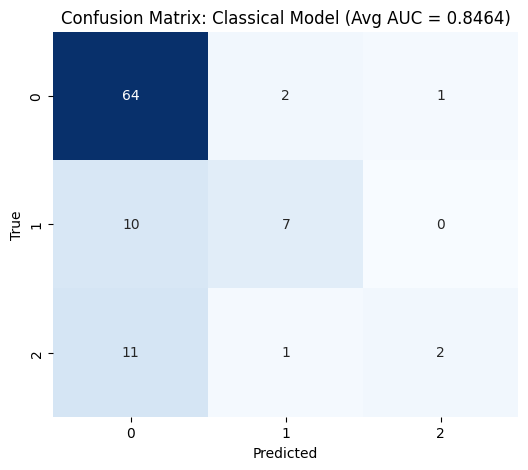

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)